### import Neccessary Libraries

In [1]:
import os 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time 
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [4]:
dataset_path ="./dataset"

dataset = datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

2300

In [37]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

### Training Dataset

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size,val_size

(1725, 575)

In [8]:
from torch.utils.data import random_split

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

In [9]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

In [10]:
for images ,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
images[1].shape

torch.Size([3, 224, 224])

In [12]:
labels[1]

tensor(3)

In [13]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


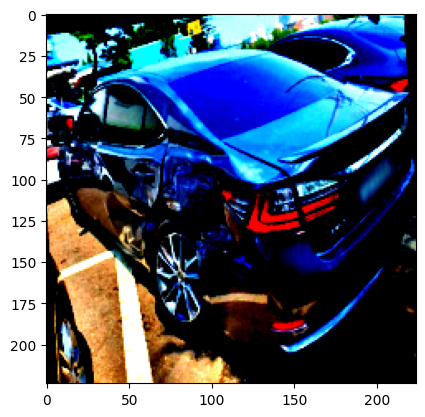

In [14]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

### Model 1 : CNN

In [15]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),  #(16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),  #(32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),  #(64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )

    def forward(self,x):
        x = self.network(x)
        return x

In [16]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [17]:
def train_model(model,criterion,optimizer,epochs=5):
    start = time.time()
    
    #Training
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num,(images , labels) in enumerate(train_loader):
            images,labels = images.to(device),labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(images)
            loss = criterion(output,labels)
            
            # Backward pass & optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1} , Loss {loss.item():0.2f}")
    
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")
    
        # Validation
        model.eval()
        total = 0
        correct = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images , labels in val_loader:
                images,labels = images.to(device),labels.to(device)
                output = model(images)
                _,predicted = torch.max(output.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy:{100* correct / total:.2f} % ***")

    end = time.time()
    print(f"Execution time : {end - start} Seconds")
    
    return all_labels,all_predictions

In [18]:
all_labels,all_predictions = train_model(model,criterion,optimizer,epochs=5)

Batch: 10, Epoch: 1 , Loss 1.71
Batch: 20, Epoch: 1 , Loss 1.65
Batch: 30, Epoch: 1 , Loss 1.42
Batch: 40, Epoch: 1 , Loss 1.22
Batch: 50, Epoch: 1 , Loss 1.49
Epoch [1/5], Avg Loss: 1.6517
*** Validation Accuracy:47.13 % ***
Batch: 10, Epoch: 2 , Loss 1.13
Batch: 20, Epoch: 2 , Loss 0.97
Batch: 30, Epoch: 2 , Loss 1.03
Batch: 40, Epoch: 2 , Loss 1.17
Batch: 50, Epoch: 2 , Loss 1.01
Epoch [2/5], Avg Loss: 1.1637
*** Validation Accuracy:47.30 % ***
Batch: 10, Epoch: 3 , Loss 1.07
Batch: 20, Epoch: 3 , Loss 1.02
Batch: 30, Epoch: 3 , Loss 0.89
Batch: 40, Epoch: 3 , Loss 1.24
Batch: 50, Epoch: 3 , Loss 0.84
Epoch [3/5], Avg Loss: 0.9874
*** Validation Accuracy:55.13 % ***
Batch: 10, Epoch: 4 , Loss 0.82
Batch: 20, Epoch: 4 , Loss 1.00
Batch: 30, Epoch: 4 , Loss 0.93
Batch: 40, Epoch: 4 , Loss 0.92
Batch: 50, Epoch: 4 , Loss 0.79
Epoch [4/5], Avg Loss: 0.8623
*** Validation Accuracy:54.26 % ***
Batch: 10, Epoch: 5 , Loss 0.74
Batch: 20, Epoch: 5 , Loss 0.86
Batch: 30, Epoch: 5 , Loss 0.70


### Model 2 : CNN with Regularization

In [19]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),  #(16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),  #(32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),  #(64,56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.5,num_classes),
            nn.Linear(512,num_classes)
        )

    def forward(self,x):
        x = self.network(x)
        return x

In [20]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

all_labels,all_predictions = train_model(model,criterion,optimizer,epochs=10)

Batch: 10, Epoch: 1 , Loss 1.79
Batch: 20, Epoch: 1 , Loss 1.76
Batch: 30, Epoch: 1 , Loss 1.61
Batch: 40, Epoch: 1 , Loss 1.30
Batch: 50, Epoch: 1 , Loss 1.48
Epoch [1/10], Avg Loss: 1.9164
*** Validation Accuracy:37.74 % ***
Batch: 10, Epoch: 2 , Loss 1.27
Batch: 20, Epoch: 2 , Loss 1.34
Batch: 30, Epoch: 2 , Loss 1.27
Batch: 40, Epoch: 2 , Loss 1.20
Batch: 50, Epoch: 2 , Loss 1.38
Epoch [2/10], Avg Loss: 1.3301
*** Validation Accuracy:45.39 % ***
Batch: 10, Epoch: 3 , Loss 1.13
Batch: 20, Epoch: 3 , Loss 1.08
Batch: 30, Epoch: 3 , Loss 0.97
Batch: 40, Epoch: 3 , Loss 1.11
Batch: 50, Epoch: 3 , Loss 1.20
Epoch [3/10], Avg Loss: 1.1561
*** Validation Accuracy:47.65 % ***
Batch: 10, Epoch: 4 , Loss 1.04
Batch: 20, Epoch: 4 , Loss 0.97
Batch: 30, Epoch: 4 , Loss 1.20
Batch: 40, Epoch: 4 , Loss 1.12
Batch: 50, Epoch: 4 , Loss 1.07
Epoch [4/10], Avg Loss: 1.0975
*** Validation Accuracy:49.91 % ***
Batch: 10, Epoch: 5 , Loss 0.89
Batch: 20, Epoch: 5 , Loss 0.98
Batch: 30, Epoch: 5 , Loss 0

### Model 3 : Transfer Learning With Efficient Net

In [30]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes)
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [31]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()),lr=0.001)
criterion = nn.CrossEntropyLoss()

all_labels,all_predictions = train_model(model,criterion,optimizer,epochs=10)

Batch: 10, Epoch: 1 , Loss 1.75
Batch: 20, Epoch: 1 , Loss 1.44
Batch: 30, Epoch: 1 , Loss 1.46
Batch: 40, Epoch: 1 , Loss 1.34
Batch: 50, Epoch: 1 , Loss 1.23
Epoch [1/10], Avg Loss: 1.5021
*** Validation Accuracy:55.48 % ***
Batch: 10, Epoch: 2 , Loss 1.18
Batch: 20, Epoch: 2 , Loss 1.18
Batch: 30, Epoch: 2 , Loss 1.18
Batch: 40, Epoch: 2 , Loss 1.31
Batch: 50, Epoch: 2 , Loss 1.19
Epoch [2/10], Avg Loss: 1.1465
*** Validation Accuracy:59.83 % ***
Batch: 10, Epoch: 3 , Loss 1.10
Batch: 20, Epoch: 3 , Loss 1.06
Batch: 30, Epoch: 3 , Loss 1.30
Batch: 40, Epoch: 3 , Loss 1.04
Batch: 50, Epoch: 3 , Loss 0.92
Epoch [3/10], Avg Loss: 1.0308
*** Validation Accuracy:64.70 % ***
Batch: 10, Epoch: 4 , Loss 0.95
Batch: 20, Epoch: 4 , Loss 1.04
Batch: 30, Epoch: 4 , Loss 0.84
Batch: 40, Epoch: 4 , Loss 1.00
Batch: 50, Epoch: 4 , Loss 0.91
Epoch [4/10], Avg Loss: 0.9687
*** Validation Accuracy:62.43 % ***
Batch: 10, Epoch: 5 , Loss 0.88
Batch: 20, Epoch: 5 , Loss 1.09
Batch: 30, Epoch: 5 , Loss 0

### Model 5 : Transfer Learning With ResNet

In [34]:
class CarClassifierResNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False
        
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features,num_classes)
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [35]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()),lr=0.001)
criterion = nn.CrossEntropyLoss()

all_labels,all_predictions = train_model(model,criterion,optimizer,epochs=10)

Batch: 10, Epoch: 1 , Loss 0.94
Batch: 20, Epoch: 1 , Loss 0.82
Batch: 30, Epoch: 1 , Loss 1.07
Batch: 40, Epoch: 1 , Loss 0.91
Batch: 50, Epoch: 1 , Loss 0.52
Epoch [1/10], Avg Loss: 0.8704
*** Validation Accuracy:72.70 % ***
Batch: 10, Epoch: 2 , Loss 0.32
Batch: 20, Epoch: 2 , Loss 0.53
Batch: 30, Epoch: 2 , Loss 0.58
Batch: 40, Epoch: 2 , Loss 0.43
Batch: 50, Epoch: 2 , Loss 0.56
Epoch [2/10], Avg Loss: 0.5054
*** Validation Accuracy:78.96 % ***
Batch: 10, Epoch: 3 , Loss 0.40
Batch: 20, Epoch: 3 , Loss 0.23
Batch: 30, Epoch: 3 , Loss 0.17
Batch: 40, Epoch: 3 , Loss 0.40
Batch: 50, Epoch: 3 , Loss 0.39
Epoch [3/10], Avg Loss: 0.3231
*** Validation Accuracy:78.96 % ***
Batch: 10, Epoch: 4 , Loss 0.24
Batch: 20, Epoch: 4 , Loss 0.15
Batch: 30, Epoch: 4 , Loss 0.45
Batch: 40, Epoch: 4 , Loss 0.32
Batch: 50, Epoch: 4 , Loss 0.20
Epoch [4/10], Avg Loss: 0.2393
*** Validation Accuracy:82.26 % ***
Batch: 10, Epoch: 5 , Loss 0.12
Batch: 20, Epoch: 5 , Loss 0.22
Batch: 30, Epoch: 5 , Loss 0

##### I Ran hyperparameter tunning process in hyper_parameter_tuning notebook and figured out that best parameters for the models are (1) dropout_rate = 0.6889    (2) lr = 0.0008

### Model ResNet With Hyperparameter Tunning

In [38]:
class CarClassifierResNet(nn.Module):
    def __init__(self,num_classes,dropout_rate):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False
        
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features,num_classes)
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [39]:
model = CarClassifierResNet(num_classes=num_classes,dropout_rate=0.6889).to(device)
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()),lr=0.0008)
criterion = nn.CrossEntropyLoss()

labels,predictions = train_model(model,criterion,optimizer,epochs=10)

Batch: 10, Epoch: 1 , Loss 1.42
Batch: 20, Epoch: 1 , Loss 0.80
Batch: 30, Epoch: 1 , Loss 0.68
Batch: 40, Epoch: 1 , Loss 0.98
Batch: 50, Epoch: 1 , Loss 0.67
Epoch [1/10], Avg Loss: 0.9722
*** Validation Accuracy:75.83 % ***
Batch: 10, Epoch: 2 , Loss 0.35
Batch: 20, Epoch: 2 , Loss 0.45
Batch: 30, Epoch: 2 , Loss 0.52
Batch: 40, Epoch: 2 , Loss 0.36
Batch: 50, Epoch: 2 , Loss 0.44
Epoch [2/10], Avg Loss: 0.5162
*** Validation Accuracy:77.39 % ***
Batch: 10, Epoch: 3 , Loss 0.38
Batch: 20, Epoch: 3 , Loss 0.28
Batch: 30, Epoch: 3 , Loss 0.42
Batch: 40, Epoch: 3 , Loss 0.48
Batch: 50, Epoch: 3 , Loss 0.62
Epoch [3/10], Avg Loss: 0.3785
*** Validation Accuracy:81.04 % ***
Batch: 10, Epoch: 4 , Loss 0.24
Batch: 20, Epoch: 4 , Loss 0.15
Batch: 30, Epoch: 4 , Loss 0.27
Batch: 40, Epoch: 4 , Loss 0.34
Batch: 50, Epoch: 4 , Loss 0.20
Epoch [4/10], Avg Loss: 0.2693
*** Validation Accuracy:80.17 % ***
Batch: 10, Epoch: 5 , Loss 0.35
Batch: 20, Epoch: 5 , Loss 0.11
Batch: 30, Epoch: 5 , Loss 0

### Model Evaluation Using Confusion Matrix and Classification Report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(labels,predictions)
print(report)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(labels,predictions,labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=class_names)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save and export the model

In [ ]:
torch.save(model.state_dict(),'saved_model.pth')